# Create a feature engineering pipeline

In Section 1, you tabularized a sales time series dataset to forecast sales for the next week.

In this assignment, your task is to line up those feature engineering steps within a pipeline to directly obtain the features from the input data and then forecast sales using Lasso.

The most straightforward method is probably to use the open-source library Feature-engine. But you are welcome to use other libraries, code your transformers manually, or, why not, code our own pipeline?

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [1]:
import pandas as pd

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [2]:
# load weekly sales dataset

# Adjust the following function based on where 
# you stored the dataset
filename = "../../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


## Plot time series

<AxesSubplot: xlabel='week'>

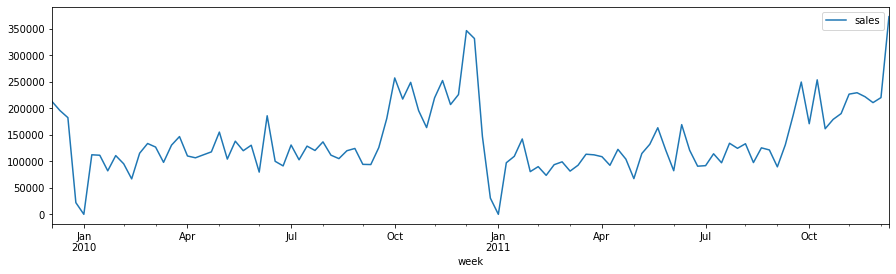

In [3]:
df.plot(figsize=[15, 4])

## Feature engineering

These are the feature engineering steps that you need to fit into a pipeline:

- Datetime features: Create the feature **month** from the timestamp.
- Cyclical features: transform the month with the sine and cosine functions.
- Lag features: Create the feature lag-1 by lagging 1 week of data.
- Window features: take the min, max and average sales values in the past 2 and 4 weeks of data.
- Drop missing data.

First set up suitable transformers / transformations and make sure they work.

In [4]:
# Create the feature month from the timestamp.

dtf = DatetimeFeatures(
    variables="index",
    features_to_extract=["month"],
)

df = dtf.fit_transform(df)

df.head()

,sales,month
week,,
2009-12-06,213000.35,12
2009-12-13,195810.04,12
2009-12-20,182396.74,12
2009-12-27,22007.77,12
2010-01-03,0.00,1


In [5]:
# Transform the month with the sine and cosine functions

cyclical = CyclicalFeatures(
    variables=["month"],
    drop_original=False,
)

df = cyclical.fit_transform(df)

df.head()

,sales,month,month_sin,month_cos
week,,,,
2009-12-06,213000.35,12,-2.449294e-16,1.000000
2009-12-13,195810.04,12,-2.449294e-16,1.000000
2009-12-20,182396.74,12,-2.449294e-16,1.000000
2009-12-27,22007.77,12,-2.449294e-16,1.000000
2010-01-03,0.00,1,5.000000e-01,0.866025


In [6]:
# Create the feature lag-1 by lagging 1 week of data.

lagf = LagFeatures(
    variables=["sales"],
    freq=["1W"],
    missing_values="ignore",
)

df = lagf.fit_transform(df)

df.head()

,sales,month,month_sin,month_cos,sales_lag_1W
week,,,,,
2009-12-06,213000.35,12,-2.449294e-16,1.000000,NaN
2009-12-13,195810.04,12,-2.449294e-16,1.000000,213000.35
2009-12-20,182396.74,12,-2.449294e-16,1.000000,195810.04
2009-12-27,22007.77,12,-2.449294e-16,1.000000,182396.74
2010-01-03,0.00,1,5.000000e-01,0.866025,22007.77


In [7]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.

winf = WindowFeatures(
    variables=["sales"],
    window=[2,4],
    freq="1W",
    functions=['mean', "max", "min"],
    missing_values="ignore",
)

df = winf.fit_transform(df)

df.head()

,sales,month,month_sin,month_cos,sales_lag_1W,sales_window_2_mean,sales_window_2_max,sales_window_2_min,sales_window_4_mean,sales_window_4_max,sales_window_4_min
week,,,,,,,,,,,
2009-12-06,213000.35,12,-2.449294e-16,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,195810.04,12,-2.449294e-16,1.000000,213000.35,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-20,182396.74,12,-2.449294e-16,1.000000,195810.04,204405.195,213000.35,195810.04,NaN,NaN,NaN
2009-12-27,22007.77,12,-2.449294e-16,1.000000,182396.74,189103.390,195810.04,182396.74,NaN,NaN,NaN
2010-01-03,0.00,1,5.000000e-01,0.866025,22007.77,102202.255,182396.74,22007.77,153303.725,213000.35,22007.77


In [8]:
# Drop missing data.

imputer = DropMissingData()

df = imputer.fit_transform(df)

df.head()

,sales,month,month_sin,month_cos,sales_lag_1W,sales_window_2_mean,sales_window_2_max,sales_window_2_min,sales_window_4_mean,sales_window_4_max,sales_window_4_min
week,,,,,,,,,,,
2010-01-03,0.000,1,0.5,0.866025,22007.770,102202.2550,182396.74,22007.770,153303.72500,213000.35,22007.77
2010-01-10,112318.850,1,0.5,0.866025,0.000,11003.8850,22007.77,0.000,100053.63750,195810.04,0.00
2010-01-17,111460.470,1,0.5,0.866025,112318.850,56159.4250,112318.85,0.000,79180.84000,182396.74,0.00
2010-01-24,82065.331,1,0.5,0.866025,111460.470,111889.6600,112318.85,111460.470,61446.77250,112318.85,0.00
2010-01-31,110790.591,1,0.5,0.866025,82065.331,96762.9005,111460.47,82065.331,76461.16275,112318.85,0.00


In [9]:
# Drop original time series

drop_ts = DropFeatures(features_to_drop=["sales"])

df = drop_ts.fit_transform(df)

df.head()

,month,month_sin,month_cos,sales_lag_1W,sales_window_2_mean,sales_window_2_max,sales_window_2_min,sales_window_4_mean,sales_window_4_max,sales_window_4_min
week,,,,,,,,,,
2010-01-03,1,0.5,0.866025,22007.770,102202.2550,182396.74,22007.770,153303.72500,213000.35,22007.77
2010-01-10,1,0.5,0.866025,0.000,11003.8850,22007.77,0.000,100053.63750,195810.04,0.00
2010-01-17,1,0.5,0.866025,112318.850,56159.4250,112318.85,0.000,79180.84000,182396.74,0.00
2010-01-24,1,0.5,0.866025,111460.470,111889.6600,112318.85,111460.470,61446.77250,112318.85,0.00
2010-01-31,1,0.5,0.866025,82065.331,96762.9005,111460.47,82065.331,76461.16275,112318.85,0.00


## ML Workflow

- Load the data again.
- Split the data into a suitable train and test set.
- Align all feature engineering steps in a pipeline.
- Create the features.
- Train a model.
- Evaluate the model.

In [10]:
# load weekly sales dataset

# adjust the following function based on where 
# you stored the dataset
filename = "../../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


In [11]:
df.index.min(), df.index.max()

(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [12]:
# The offset for the test set

pd.Timestamp("2011-09-30") - pd.offsets.Week(10)

Timestamp('2011-07-22 00:00:00')

In [13]:
# Split the data in time.

X_train = df[df.index <= "2011-09-30"]
X_test = df[df.index > pd.Timestamp("2011-09-30") - pd.offsets.Week(10)]

X_train.shape, X_test.shape

((95, 1), (21, 1))

In [14]:
# target (in this dataset, is is the train set itself)

y_train = df[df.index <= "2011-09-30"]["sales"]
y_test = df[df.index > pd.Timestamp("2011-09-30") - pd.offsets.Week(10)]["sales"]

y_train.shape, y_test.shape

((95,), (21,))

## Pipeline

Set up the pipeline and test it.

In [15]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("Periodic", cyclical),
        ("lagf", lagf),
        ("winf", winf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

In [16]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,month_sin,month_cos,sales_lag_1W,sales_window_2_mean,sales_window_2_max,sales_window_2_min,sales_window_4_mean,sales_window_4_max,sales_window_4_min
week,,,,,,,,,,
2010-01-03,1,0.5,0.866025,22007.770,102202.2550,182396.74,22007.770,153303.72500,213000.35,22007.77
2010-01-10,1,0.5,0.866025,0.000,11003.8850,22007.77,0.000,100053.63750,195810.04,0.00
2010-01-17,1,0.5,0.866025,112318.850,56159.4250,112318.85,0.000,79180.84000,182396.74,0.00
2010-01-24,1,0.5,0.866025,111460.470,111889.6600,112318.85,111460.470,61446.77250,112318.85,0.00
2010-01-31,1,0.5,0.866025,82065.331,96762.9005,111460.47,82065.331,76461.16275,112318.85,0.00


In [17]:
# Create the features in the test set

X_test_t =  pipe.transform(X_test)

X_test_t.head()

,month,month_sin,month_cos,sales_lag_1W,sales_window_2_mean,sales_window_2_max,sales_window_2_min,sales_window_4_mean,sales_window_4_max,sales_window_4_min
week,,,,,,,,,,
2011-08-21,8,-0.866025,-5.000000e-01,97651.84,115403.605,133155.37,97651.84,122357.96275,134081.78,97651.84
2011-08-28,8,-0.866025,-5.000000e-01,125420.95,111536.395,125420.95,97651.84,120192.75525,133155.37,97651.84
2011-09-04,9,-1.000000,-1.836970e-16,121444.74,123432.845,125420.95,121444.74,119418.22500,133155.37,97651.84
2011-09-11,9,-1.000000,-1.836970e-16,89577.65,105511.195,121444.74,89577.65,108523.79500,125420.95,89577.65
2011-09-18,9,-1.000000,-1.836970e-16,131164.24,110370.945,131164.24,89577.65,116901.89500,131164.24,89577.65


In [18]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train.loc[X_train_t.index]

print(y_train_t.shape)

(95,)
(91,)


In [19]:
print(y_test.shape)

y_test_t = y_test.loc[X_test_t.index]

print(y_test_t.shape)

(21,)
(17,)


## Lasso

In [20]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  0.001725597994861934
test rmse:  0.0024940282511417495
